Going to divde this notebook into a few subsections:

1) Results from data exploration done in other notebook
2) Train/val/test split 
3) Try a few different model architectures

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import unittest

In [2]:
df = pd.read_csv("/Users/loganroberts/Learn2Therm/ValidProt/data/Sample.csv")

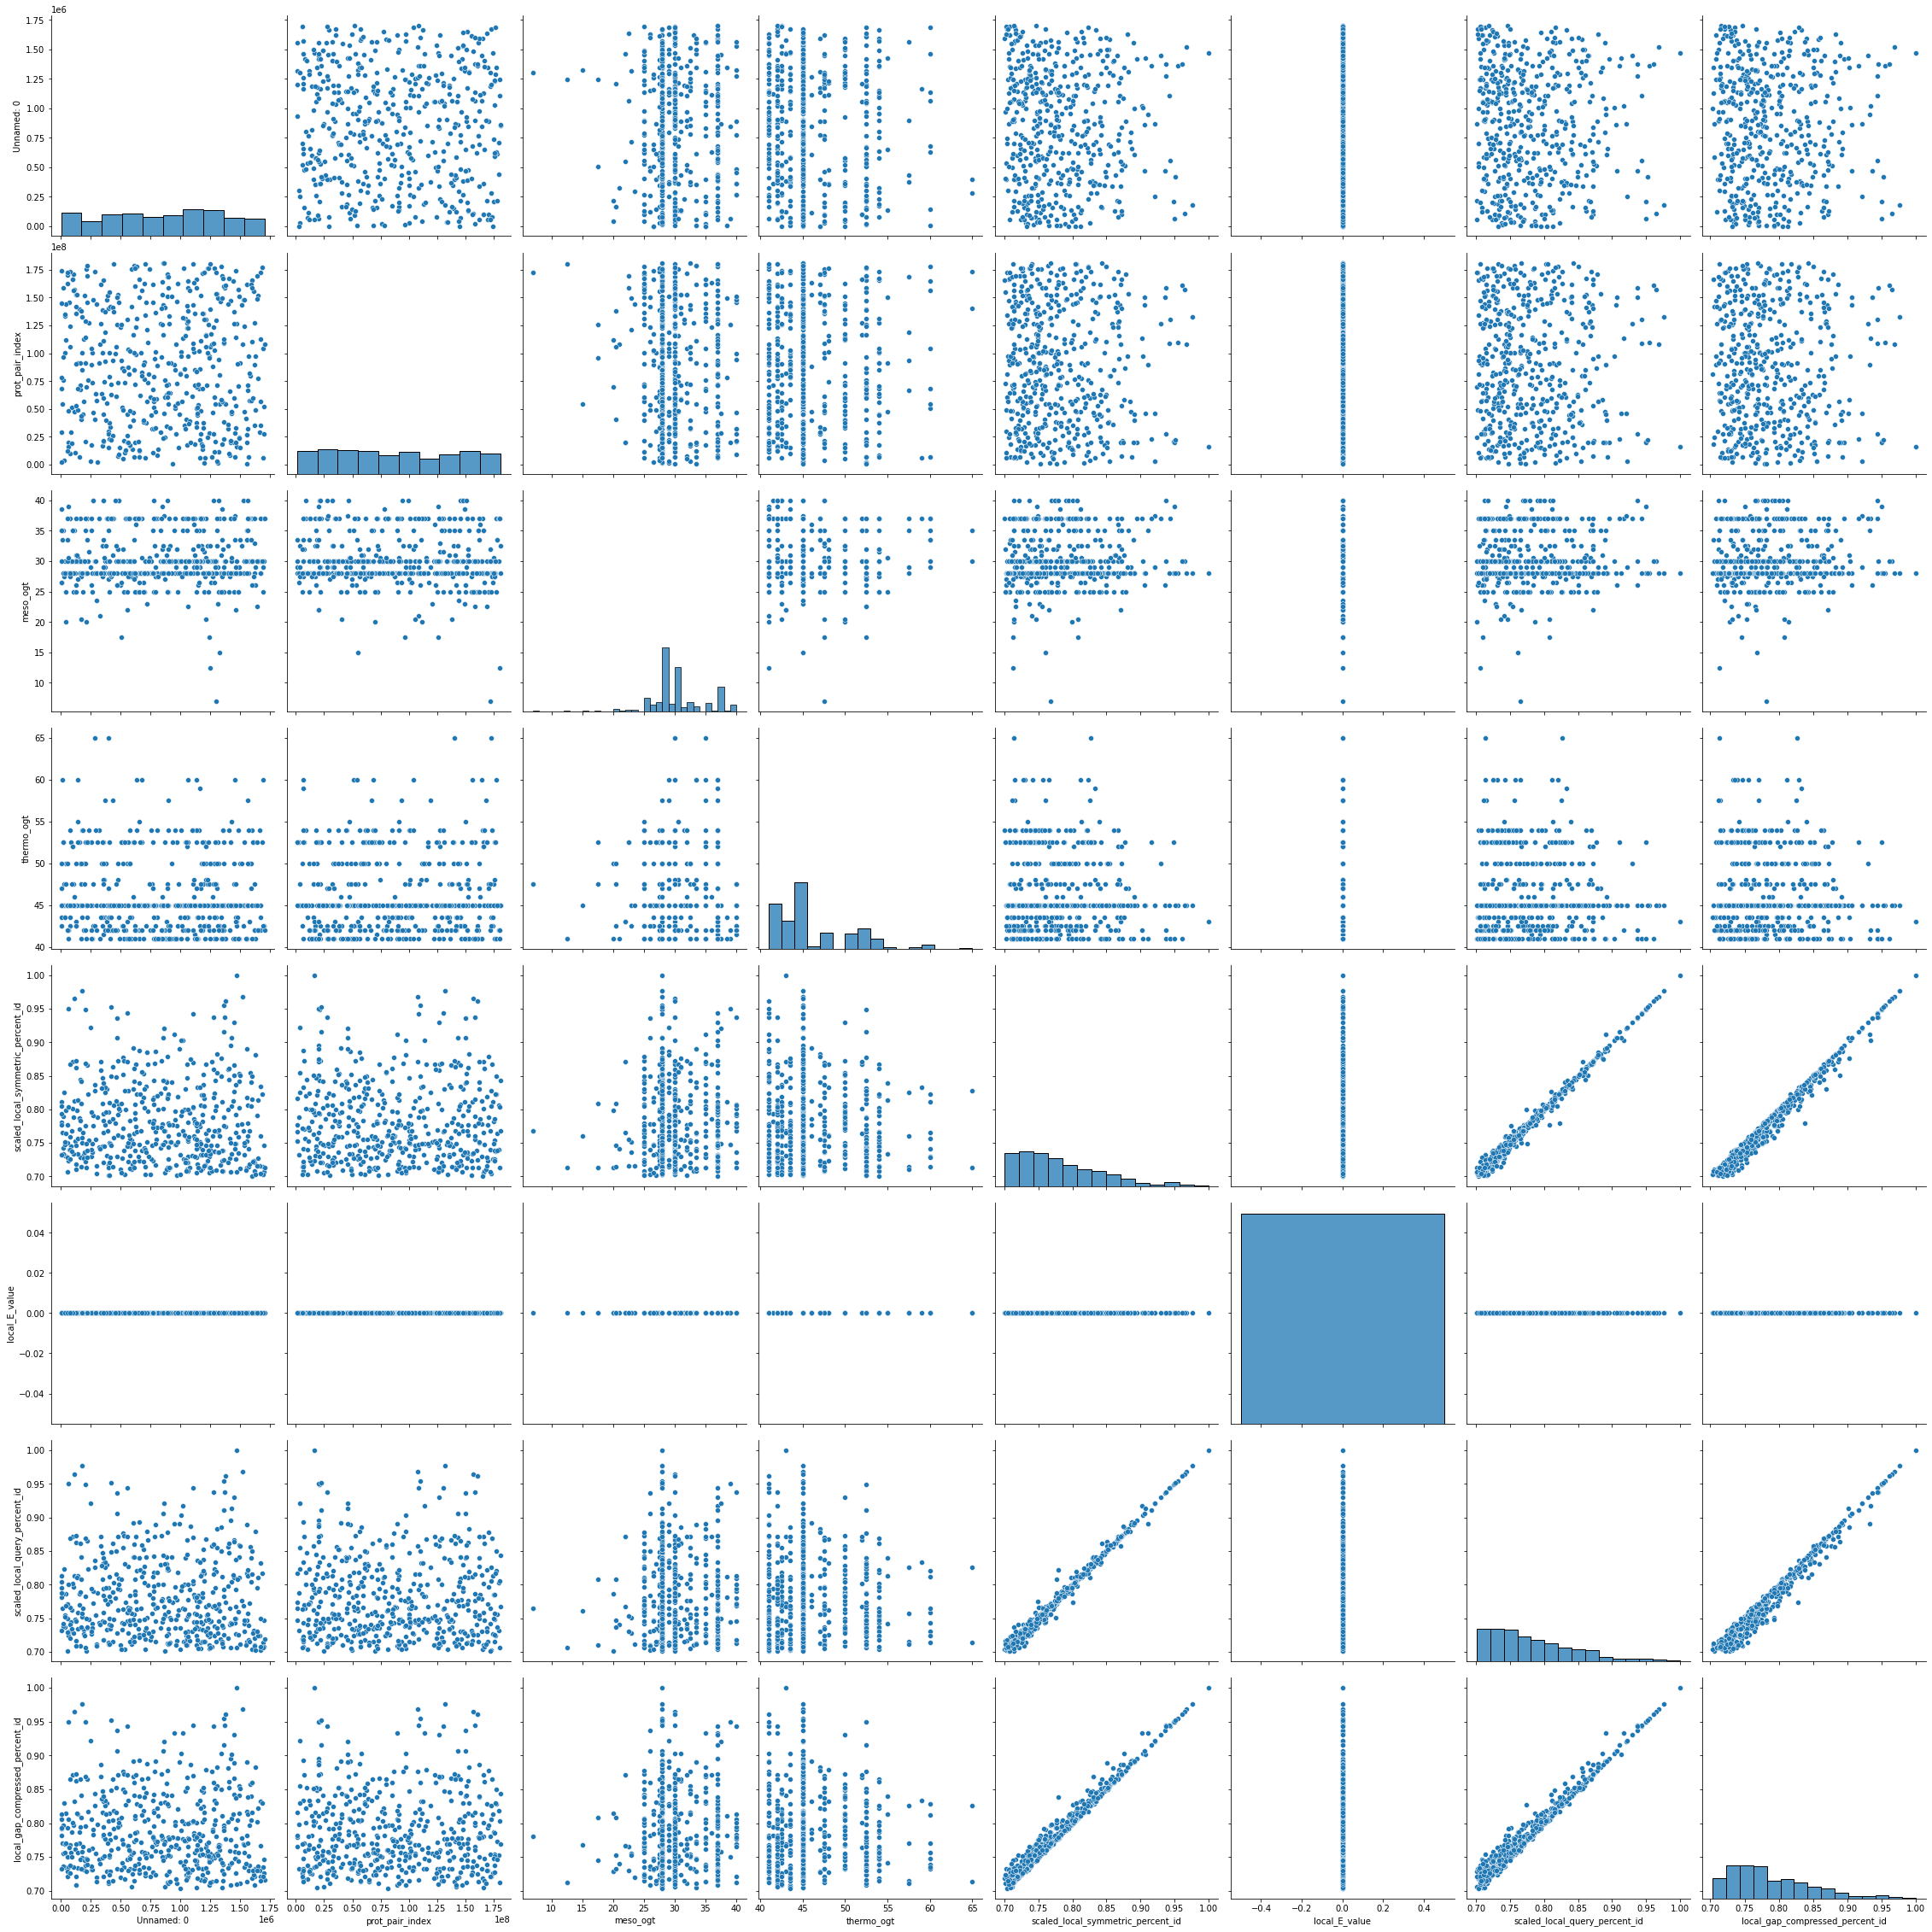

In [3]:
sns.pairplot(df.sample(500),height = 4)

In [4]:
#drop columns without linear relationship. Meso/Thermo OGT don't have a relationship either, but let's leave these in for now

df = df.drop(columns = ['Unnamed: 0', 'prot_pair_index', 'meso_seq', 'thermo_seq'])
df.head()

,meso_ogt,thermo_ogt,scaled_local_symmetric_percent_id,local_E_value,scaled_local_query_percent_id,local_gap_compressed_percent_id
0,27.5,45.0,0.777202,0.0,0.773196,0.802139
1,30.0,54.0,0.782143,0.0,0.784946,0.784946
2,19.5,54.0,0.775194,0.0,0.775194,0.775194
3,28.0,52.5,0.787770,0.0,0.790614,0.802198
4,28.0,45.0,0.788350,0.0,0.780769,0.802372


In [5]:
df.describe()

,meso_ogt,thermo_ogt,scaled_local_symmetric_percent_id,local_E_value,scaled_local_query_percent_id,local_gap_compressed_percent_id
count,10000.00000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,30.08420,46.312800,0.783622,0.0,0.783884,0.790798
std,4.44445,4.612476,0.063729,0.0,0.063812,0.062298
min,7.00000,41.000000,0.700129,0.0,0.700252,0.700272
25%,28.00000,42.500000,0.732143,0.0,0.732323,0.741071
50%,30.00000,45.000000,0.769532,0.0,0.769813,0.777480
75%,32.50000,50.000000,0.820513,0.0,0.821565,0.827957
max,40.00000,70.000000,1.000000,0.0,1.000000,1.000000


Text(0, 0.5, 'Count')

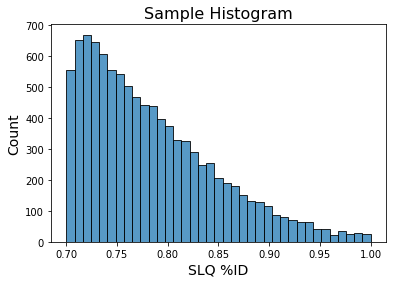

In [6]:
#plot empirical distribution of scaled_local_query_percent_id

target = df['scaled_local_query_percent_id']
#create histplot
fig, ax = plt.subplots()

sns.histplot(data = df, x = target)

ax.set_title('Sample Histogram', fontsize=16)
ax.set_xlabel('SLQ %ID', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

In [7]:
print('The mean is : {} and the standard deviation is {}.'.format(target.mean(),target.std())) 

The mean is : 0.7838843284720001 and the standard deviation is 0.06381240225848861.


1) Split dev and test data:

In [8]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.20, random_state=1)

print(dev.shape)
print(test.shape)

(8000, 6)
(2000, 6)


In [9]:
#see if there is a linear correlation between feature and target


pearson_corr = dev.corr(method = 'pearson')['scaled_local_query_percent_id']

pearson_corr.abs() < 0.03

meso_ogt                              True
thermo_ogt                           False
scaled_local_symmetric_percent_id    False
local_E_value                        False
scaled_local_query_percent_id        False
local_gap_compressed_percent_id      False
Name: scaled_local_query_percent_id, dtype: bool

In [10]:
#predicting values 

dev_X = dev[['meso_ogt', 'thermo_ogt', 'scaled_local_symmetric_percent_id',
       'local_E_value','local_gap_compressed_percent_id']].values
test_X = test[['meso_ogt', 'thermo_ogt', 'scaled_local_symmetric_percent_id',
       'local_E_value','local_gap_compressed_percent_id']].values

dev_y = dev['scaled_local_query_percent_id'].values.reshape(-1,1)
test_y = test['scaled_local_query_percent_id'].values.reshape(-1,1)  

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(8000, 5) (2000, 5) (8000, 1) (2000, 1)


2) Scale the data

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)

3) Regularize the data -L1 or L2? Read online

4. Train the model

In [12]:
model = sklearn.linear_model.LinearRegression()
type(model.fit(dev_X, dev_y))

sklearn.linear_model._base.LinearRegression

5. Test the model, report MSE and MAE

In [13]:
R2 = model.score(test_X, test_y)
print('R2 score is: {}'.format(R2))

preds = model.predict(test_X)
preds[0:10]

R2 score is: 0.987980207555011


array([[0.75393097],
       [0.72838639],
       [0.76871827],
       [0.72819197],
       [0.83310604],
       [0.73375304],
       [0.88817202],
       [0.78517107],
       [0.82709274],
       [0.80197727]])

y = 1.0187x + -0.0119
R2 = 0.988


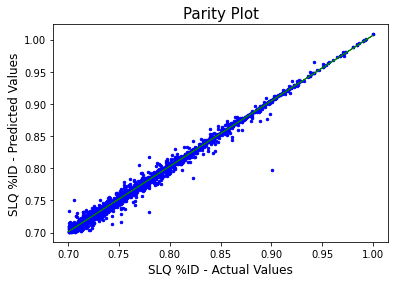

In [14]:
# make a plot to show the fit
fig, ax = plt.subplots()

# plot the actual vs. predicted values
ax.scatter(test_y, preds, c='b',s=6, label='Parity Plot')
plt.xlabel("SLQ %ID - Actual Values", fontsize=12)
plt.ylabel("SLQ %ID - Predicted Values", fontsize=12)
plt.title('Parity Plot', fontsize=15)

#plot line of best fit
slope, intercept = np.polyfit(np.ravel(test_y), preds, 1)
plt.plot(np.ravel(test_y), slope*np.ravel(test_y) + intercept, c='green', lw=1)
print('y = {}x + {}'.format(round(float(slope),4), round(float(intercept),4)))
print('R2 = {}'.format(round(R2,4)))

#add mean squared error 

In [15]:
mae = sklearn.metrics.mean_absolute_error(test_y, preds)
mse = sklearn.metrics.mean_squared_error(test_y, preds)

print("The MAE is : {} and the MSE is: {}".format(round(mae,6), round(mse,6)))

The MAE is : 0.004784 and the MSE is: 4.7e-05


Make stuff from above into a few functions.

In [16]:
def train_reg(dataframe, columns = [],  target = []):
    """
    Takes a dataframe and trains a standard Linear Regression model with selected data.
    
    Params
    ----------
    dataframe: Pandas dataframe
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Pearson correlation between each input and the output feature
    -Linear regression model
    -input test data vector (numpy array)
    -feature test vector (numpy array)
    """
    
    #test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(dataframe))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))
    
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.20, random_state=1)
    
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #return pearson correlation for linear correlation
    pearson_corr = dev.corr(method = 'pearson')[target]
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.linear_model.LinearRegression()
    model = model.fit(dev_X, dev_y)
    
    return pearson_corr, model, test_X, test_y
    

In [17]:
p_corr, model, test_X, test_y = train_reg(df, columns = ['meso_ogt', 'thermo_ogt', 
                                                         'scaled_local_symmetric_percent_id',
                                                         'local_E_value','local_gap_compressed_percent_id'], 
                                          target = ['scaled_local_query_percent_id'])

In [24]:
#test code-need to update

class TestModelTraining(unittest.TestCase):
    
    def test_invalid_inputs(self):
    
        #test that input dimensions are correct
        try:
            train_reg(another_df)
            self.assertTrue(False)
        except ValueError:
            self.assertTrue(True)
    
#     def test_pairwise_corr(self):
#         #test that output dimensions are correct
#         num_rows = df.iloc[:]
#         num_cols = df[:]
#         assert pairwise_correlation(df).shape == (len(num_rows),len(num_cols)), "Dimensions are not equal."
        
#     def test_result_type(self):
#         #test that output data type is correct
#         assert "pandas.core.frame.DataFrame" in str(type(train_reg(df))), "Not a Pandas Dataframe!"

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelTraining)
_ = unittest.TextTestRunner().run(suite)

E
ERROR: test_invalid_inputs (__main__.TestModelTraining)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-24-4487c47412ea>", line 9, in test_invalid_inputs
    train_reg(another_df)
NameError: name 'another_df' is not defined

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)


In [19]:
def test_reg(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.linear_model
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Vector of predictions based on the model (numpy array)
    -prints R2 score of the model
    -prints mean absolute error and mean squared error from model
    """
    
    #test input arguments
    assert "sklearn.linear_model" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    R2 = model.score(test_X, test_y)
    
    print('R2 score is: {}'.format(R2))

    preds = model.predict(test_X)

    mae = sklearn.metrics.mean_absolute_error(test_y, preds)
    mse = sklearn.metrics.mean_squared_error(test_y, preds)

    print("The MAE is : {} and the MSE is: {}".format(round(mae,6), round(mse,6)))
    
    return preds

In [20]:
preds = test_reg(model, test_X, test_y)
preds

R2 score is: 0.987980207555011
The MAE is : 0.004784 and the MSE is: 4.7e-05


array([[0.75393097],
       [0.72838639],
       [0.76871827],
       ...,
       [0.81447096],
       [0.75523667],
       [0.75096855]])

In [29]:
def plot_regression(model, test_X, test_y):
    """
    Takes a test Linear Regression ML model and plots the predictions against actual values.
    
    Params
    ----------
    model: sklearn.linear_model
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Parity plot of predictions vs. observations
    -Equation of line of best fit (always linear)
    -R2 score
    """
    
    #test input arguments
    assert "sklearn.linear_model" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    R2 = model.score(test_X, test_y)
    preds = test_reg(model, test_X, test_y)
    
    # make a plot to show the fit
    fig, ax = plt.subplots()

    # plot the actual vs. predicted values
    ax.scatter(test_y, preds, c='b',s=6, label='Parity Plot')
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.title('Parity Plot', fontsize=15)

    #plot line of best fit
    slope, intercept = np.polyfit(np.ravel(test_y), preds, 1)
    plt.plot(np.ravel(test_y), slope*np.ravel(test_y) + intercept, c='green', lw=1)
    print('y = {}x + {}'.format(round(float(slope),4), round(float(intercept),4)))
    print('R2 = {}'.format(round(R2,4)))